In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Newmark integration

## In Python

In [2]:
def Newmark(m, k, c, dt, f, x0 , xp0):
    """ 
    Integration with Newmark's method.
    
    See Chopra, "Dynamics of structures", Ch. 5.4
    """
     
    N = len(f)
    x = np.zeros(N)
    xp = np.zeros(N)
    xpp = np.zeros(N)
            
    # parametri Newmark
    gamma = 1./2.
    beta  = 1./4. # select 1/4. for Average acceleration method, 1/6. for linear acceleration method.
    
    # condizioni iniziali
    x[0] = x0
    xp[0] = xp0
    xpp[0] = (f[0] - c*xp0 - k*x0) / m
    # 
    k_hat = k + gamma/(beta*dt)*c + 1./(beta*dt**2)*m
    a = 1./(beta*dt)*m + gamma/beta*c
    b = 1./(2*beta)*m + dt*(gamma/(2*beta)-1)*c
            
    for j in range(0,N-1):
        # 
        df = (f[j+1]-f[j]) + a*xp[j] + b*xpp[j]
        dx = df/k_hat
        dxp = gamma/(beta*dt)*dx - gamma/beta*xp[j] + dt*(1-gamma/(2*beta))*xpp[j]
        dxpp = 1./(beta*dt**2)*dx - 1./(beta*dt)*xp[j] - 1./(2*beta)*xpp[j]
        # compute the values at step j+1
        x[j+1] = x[j] + dx
        xp[j+1] = xp[j] + dxp
        xpp[j+1] = xpp[j] + dxpp
   
    return x, xp, xpp

In [3]:
t = np.linspace(0,10,1000)
w = 2*np.pi/1.
f = np.sin(w*t)

w1 = 2*np.pi/1.2
m = 1
k = m*w1**2
v = 0.05
c = m*2*v*w1

x0 = 0
xp0 = 0

dt = t[1]-t[0]
x1, xp1, xpp1 = Newmark(m, k, c, dt, f, x0 , xp0)

In [4]:
%timeit Newmark(m, k, c, dt, f, x0 , xp0)

9.53 ms ± 4.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## In Python, optimized with Numba

In [5]:
@jit(nopython=True)
def Newmark_nb(m, k, c, dt, f, x0 , xp0):
    """ 
    Integration with Newmark's method.
    
    See Chopra, "Dynamics of structures", Ch. 5.4
    """
     
    N = len(f)
    x = np.zeros(N)
    xp = np.zeros(N)
    xpp = np.zeros(N)
            
    # parametri Newmark
    gamma = 1./2.
    beta  = 1./4. # select 1/4. for Average acceleration method, 1/6. for linear acceleration method.
    
    # condizioni iniziali
    x[0] = x0
    xp[0] = xp0
    xpp[0] = (f[0] - c*xp0 - k*x0) / m
    # 
    k_hat = k + gamma/(beta*dt)*c + 1./(beta*dt**2)*m
    a = 1./(beta*dt)*m + gamma/beta*c
    b = 1./(2*beta)*m + dt*(gamma/(2*beta)-1)*c
            
    for j in range(0,N-1):
        # 
        df = (f[j+1]-f[j]) + a*xp[j] + b*xpp[j]
        dx = df/k_hat
        dxp = gamma/(beta*dt)*dx - gamma/beta*xp[j] + dt*(1-gamma/(2*beta))*xpp[j]
        dxpp = 1./(beta*dt**2)*dx - 1./(beta*dt)*xp[j] - 1./(2*beta)*xpp[j]
        # compute the values at step j+1
        x[j+1] = x[j] + dx
        xp[j+1] = xp[j] + dxp
        xpp[j+1] = xpp[j] + dxpp
   
    return x, xp, xpp

In [6]:
x2, xp2, xpp2 = Newmark_nb(m, k, c, dt, f, x0 , xp0)

In [7]:
%timeit Newmark_nb(m, k, c, dt, f, x0 , xp0)

28.7 µs ± 7.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## In Fortran

In [8]:
import os
os.getcwd()

'/mnt/shared'

In [9]:
from newmark import newmark as Newmark_f

In [10]:
x3, xp3, xpp3 = Newmark_f(m, k, c, dt, f, x0 , xp0)

In [11]:
%timeit Newmark_f(m, k, c, dt, f, x0 , xp0)

The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
32.5 µs ± 22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Comparisons

In [12]:
print(x1[100:105])
print(x2[100:105])
print(x3[100:105])

[-0.07589827 -0.07786989 -0.07961111 -0.08111212 -0.08236387]
[-0.07589827 -0.07786989 -0.07961111 -0.08111212 -0.08236387]
[-0.07589827 -0.07786989 -0.07961111 -0.08111212 -0.08236387]


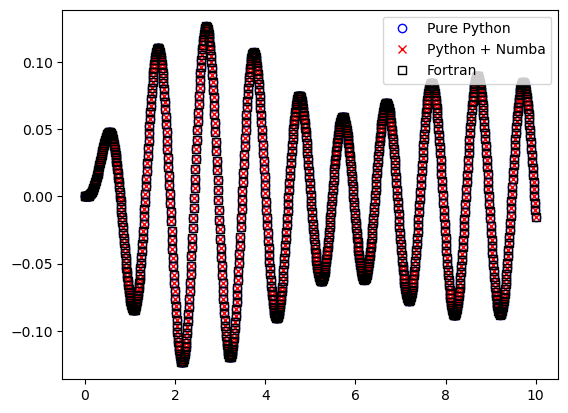

In [13]:
plt.figure()
plt.plot(t,x1,'bo',mfc='none',ms=6, label='Pure Python')
plt.plot(t,x2,'rx',ms=6, label='Python + Numba')
plt.plot(t,x3,'ks',mfc='none',ms=6, label='Fortran')
plt.legend()